Linear Regression

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


Import encoded dataframe

In [3]:
df = pd.read_pickle("df.pkl")
df_train = pd.read_pickle("df_train.pkl")
df_train_label = pd.read_pickle("df_train_label.pkl")
df_test = pd.read_pickle("df_test.pkl")
encodeDic = pd.read_pickle("dic.pkl")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117bb7a58>]],
      dtype=object)

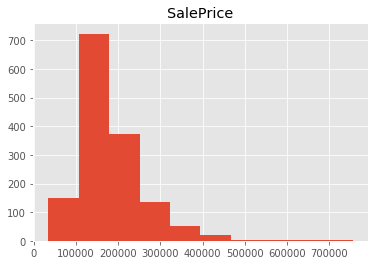

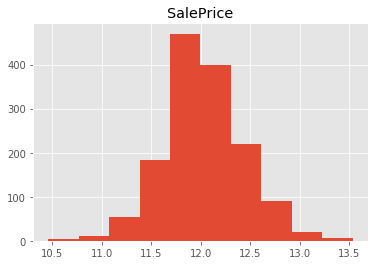

In [4]:
df_train_label = df_train_label.astype(int)
df_train_label_log = np.log( df_train_label )
df_train_label.hist()
df_train_label_log.hist()

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn import linear_model

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_train, df_train_label_log, test_size=0.2, random_state=123)

linear_1 = linear_model.LinearRegression(normalize= False)
linear_1.fit(X_train, y_train)   
preds = linear_1.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.120275


Certainly overfit. Need to do some feature selection

0.16373677157331987
0.16375252543660065
0.16566497623905943
Lasso picked 70 variables and eliminated the other 29 variables


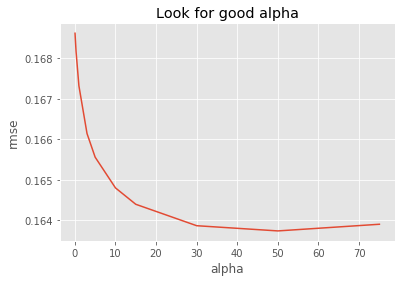

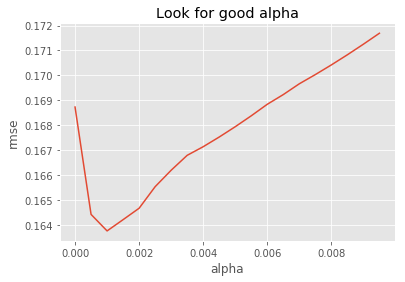

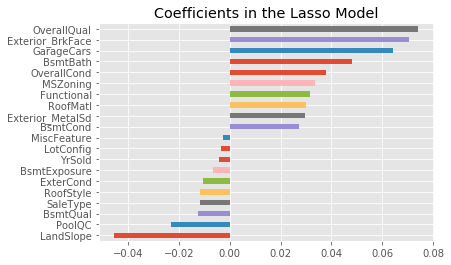

<Figure size 576x720 with 0 Axes>

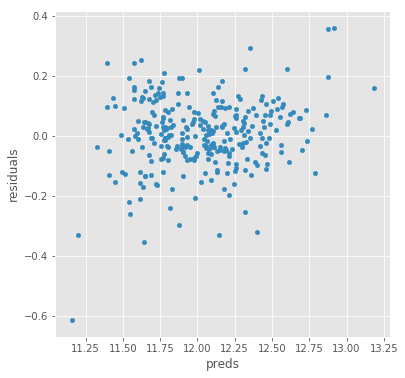

In [6]:
from sklearn.linear_model import Ridge, Lasso, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Look for good alpha")
plt.xlabel("alpha")
plt.ylabel("rmse")
print( cv_ridge.min() )

plt.figure()
model_lasso = Lasso()
alphas = np.arange(1e-10, 1e-2, 1e-4*5 )
cv_lasso = [rmse_cv(Lasso(alpha = alpha)).mean() for alpha in alphas]
#cv_lasso = [rmse_cv(Lasso(alpha = alpha, normalize=True, max_iter=1e5 )).mean() for alpha in alphas]
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Look for good alpha")
plt.xlabel("alpha")
plt.ylabel("rmse")
print( cv_lasso.min() )
model_lasso = LassoCV( alphas = alphas ).fit(X_train, y_train)
print ( rmse_cv(model_lasso).mean() )

coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

plt.figure()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")


plt.figure()
plt.rcParams['figure.figsize'] = (6.0, 6.0)
preds = y_test.copy()
preds["preds"] = model_lasso.predict(X_test)
preds["residuals"] = preds["SalePrice"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")


In [8]:
import pickle
with open('linear.pkl', 'wb') as handle:
    pickle.dump(model_lasso, handle, protocol=pickle.HIGHEST_PROTOCOL)